In [1]:
import pandas as pd
from clearml import Task

In [5]:
import clearml
clearml.__version__

'1.5.0'

In [2]:
# task_ids = Task.query_tasks(project_name='zra/0407')
task_ids = Task.query_tasks(task_filter={'parent': "b5f9c93309b04ebc98497080d4584b0b"})

# task_ids = Task.get_tasks(project_name='zra/0407')
# task_id = task_ids.pop()
# task = Task.get_task(task_id)

In [ ]:

# task = Task.get_task("d3e5bcb46d2a4a25a5df5850fda375d7")

In [ ]:
# {'dataset': {'dataset_file_name': 'dataset_ws60.parquet',
#   'dataset_id': '5dc94de095014553acbe4f011a579241'},
#  'dataset_params': {'analog_group': '150',
#   'business_unit': 'all',
#   'log_target': 'True',
#   'scaler_kwargs': '',
#   'scaling': 'Standard',
#   'split_date': '01.01.2021',
#   'target_column_name_formatter': 'predict_normalized_{}',
#   'window_size': '120'},
#  'kflod_kwargs_params': {'n_splits': '5', 'shuffle': 'False'},
#  'model_kwargs_params': {'alpha': '1.0',
#   'max_depth': '20',
#   'n_estimators': '50'},
#  'model_type_params': {'model_type': 'RandomForestRegressor',
#   'save_kfold_predicts': 'True',
#   'save_model': 'False',
#   'use_kfold': 'False'}}

In [9]:
all_data = []

# for task_id in map(lambda x: x.task_id, task_ids):
for task_id in task_ids:
    task = Task.get_task(task_id)
    # if task.status=='completed' and len(task.get_tags())>0:
    if task.status=='completed' and task.parent=="b5f9c93309b04ebc98497080d4584b0b":
        parameters = task.get_parameters_as_dict()
        scalars = task.get_reported_scalars()
                
        mae = scalars['month']['mae']
        mae = pd.Series(index=mae['x'], data=mae['y'], name=mae['name'])
        rmse = scalars['month']['rmse']
        rmse = pd.Series(index=rmse['x'], data=rmse['y'], name=rmse['name'])

        all_data.append((parameters, (mae, rmse)))


In [15]:
all_data.__len__(), task_ids.__len__()

(769, 781)

In [23]:
def parse_all_data(all_data):
    res = []

    for x in all_data:
        d = {}
        d['metrics'] = x[1]
        d['bu'] = x[0]['dataset_params']['business_unit']
        d['analog'] = x[0]['dataset_params']['analog_group']
        d['log_target'] = x[0]['dataset_params']['log_target']
        d['scaling'] = x[0]['dataset_params']['scaling']
        d['target_column_name_formatter'] = x[0]['dataset_params']['target_column_name_formatter']
        d['window_size'] = x[0]['dataset_params']['window_size']
        d['use_kfold'] = x[0]['model_type_params']['use_kfold']
        d['model_type'] = x[0]['model_type_params']['model_type']
        d['model_kwargs_params'] = x[0]['model_kwargs_params']
        d['max_depth'] = d['model_kwargs_params']['max_depth']
        d['n_estimators'] = d['model_kwargs_params']['n_estimators']
        res.append(d)
    return res

# def uniq_combinations(l: list, keys=['bu', 'analog']):
#     return set(map(lambda x: tuple([x[key] for key in keys]), l))

def make_res_df(res):
    res_df = pd.DataFrame(list(map(lambda x: {key: value for key, value in x.items() if key!='metrics'}, res)))
    res_df = res_df.merge(pd.concat(list(map(lambda x: x['metrics'][0], res)), axis=1).T.rename({i: f'mae_{i}' for i in range(12)}, axis=1).reset_index(drop=True), left_index=True, right_index=True)
    res_df = res_df.merge(pd.concat(list(map(lambda x: x['metrics'][1], res)), axis=1).T.rename({i: f'rmse_{i}' for i in range(12)}, axis=1).reset_index(drop=True), left_index=True, right_index=True)
    return res_df



In [31]:
res = parse_all_data(all_data)
res_df = make_res_df(res)

In [56]:
res_df

,bu,analog,log_target,scaling,target_column_name_formatter,window_size,use_kfold,model_type,model_kwargs_params,max_depth,...,rmse_2,rmse_3,rmse_4,rmse_5,rmse_6,rmse_7,rmse_8,rmse_9,rmse_10,rmse_11
0,all,50,False,Standard,predict_{},60,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '10', 'n_estimat...",10,...,1.979774,3.584267,5.400696,6.850678,8.569706,10.558286,12.056106,14.033750,16.203903,16.393496
1,all,50,False,Standard,predict_{},60,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '10', 'n_estimat...",10,...,1.983070,3.590913,5.406518,6.880503,8.537621,10.579199,12.106823,14.051235,16.135231,16.431988
2,all,50,False,Standard,predict_{},60,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '10', 'n_estimat...",10,...,1.998605,3.612392,5.378397,6.794609,8.568973,10.474707,12.083432,14.058629,15.947737,16.376005
3,all,50,False,Standard,predict_{},60,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '10', 'n_estimat...",10,...,1.996137,3.602031,5.391796,6.755363,8.571735,10.510737,12.096980,14.012344,15.981018,16.413954
4,all,50,False,Standard,predict_{},60,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '20', 'n_estimat...",20,...,1.988028,3.586350,5.406544,6.853436,8.528703,10.587905,12.104878,14.036822,16.140409,16.408508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,all,500,True,MinMax,predict_normalized_{},120,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '10', 'n_estimat...",10,...,0.917022,1.411382,1.726173,2.041463,2.061509,2.453817,2.539857,2.906891,2.000375,1.827926
765,all,500,True,MinMax,predict_normalized_{},120,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '10', 'n_estimat...",10,...,0.939781,1.433829,1.734477,2.031981,2.049799,2.406952,2.524546,2.871523,2.007425,1.833394
766,all,500,True,MinMax,predict_normalized_{},120,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '20', 'n_estimat...",20,...,0.941958,1.451674,1.768118,2.038002,2.095600,2.427118,2.516371,2.881226,2.063469,1.782947
767,all,500,True,MinMax,predict_normalized_{},120,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '20', 'n_estimat...",20,...,0.926679,1.429265,1.724077,2.044145,2.083878,2.480224,2.532956,2.911575,2.011011,1.792165


In [59]:
mae_cols = [f'mae_{i}' for i in range(12)]
rmse_cols = [f'rmse_{i}' for i in range(12)]

In [ ]:
for key, group in res_df.groupby('analog'):
    # print(group.shape)
    # break
    group[mae_cols].plot()
    group[rmse_cols].plot()

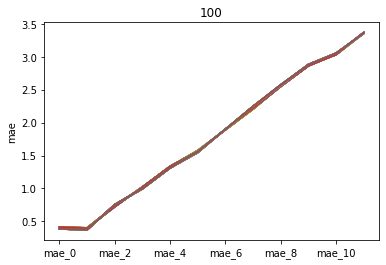

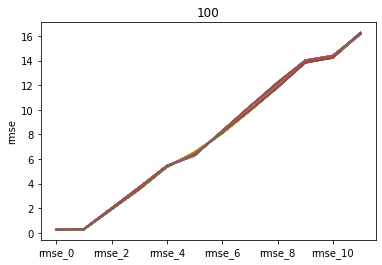

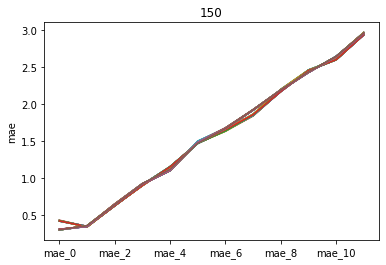

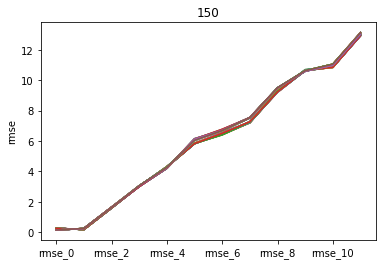

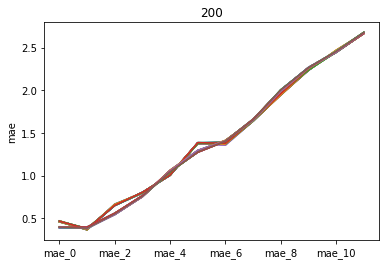

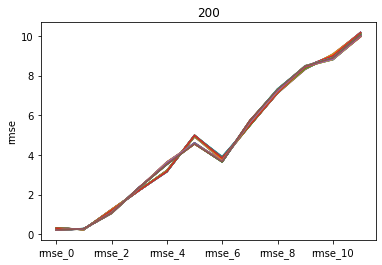

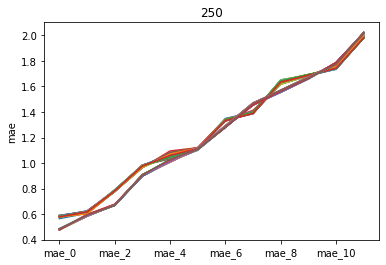

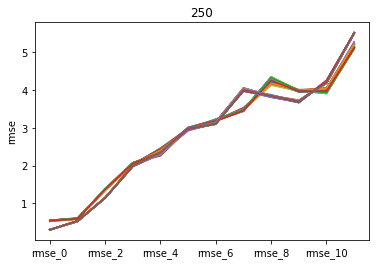

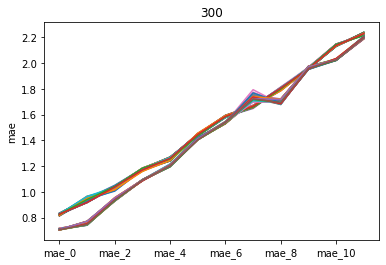

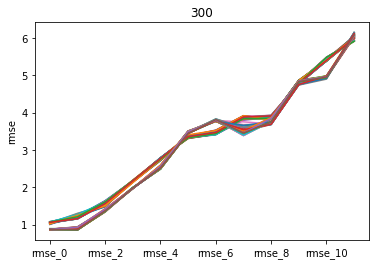

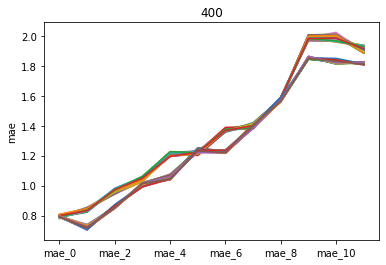

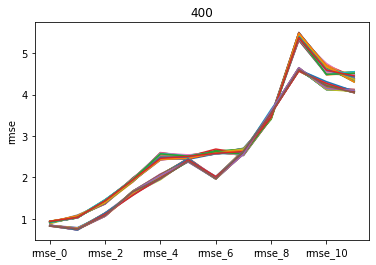

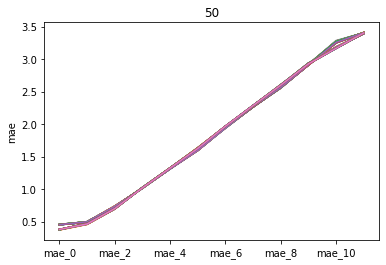

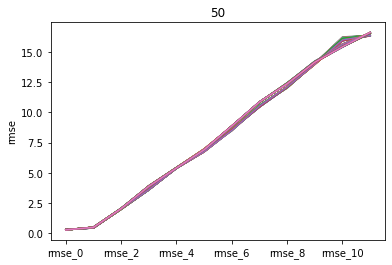

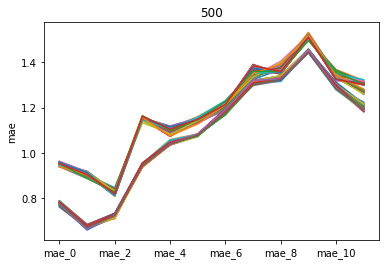

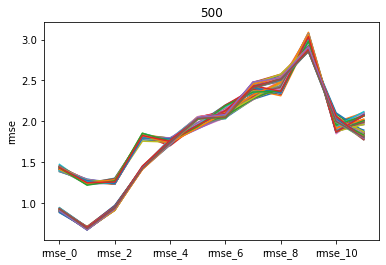

In [64]:
for key, group in res_df.groupby('analog'):
    # print(group.shape)
    # break
    group[mae_cols].T.plot(legend=False, title=key, ylabel='mae')
    group[rmse_cols].T.plot(legend=False, title=key, ylabel='rmse')

# mape

In [24]:
import pickle

In [8]:
task_ids = Task.query_tasks(task_filter={'parent': "b5f9c93309b04ebc98497080d4584b0b"})
task_id = task_ids.pop()

In [9]:
# task = Task.get_task(task_id)
task = Task.get_task("a9d8474580904ad8a70a7db35cb27bdf")

In [20]:
path = task.artifacts['model_results'].get_local_copy()

In [19]:
data

'C:/Users/user/.clearml/cache/storage_manager/global/f9f4b84c894aed5f53ea589d241eee77.model_results.pkl'

In [53]:
with open(path, 'rb') as f:
    df = pickle.load(f)

In [27]:
pd.DataFrame(df)

,0,1,2,3,4,5,6,7,8,9,10,11
columns_train_on,"[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_..."
X_test_with_predict,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...


In [39]:
len(df), len(df[0])

(12, 2)

In [32]:
df[0].keys(), df[1].keys()

(dict_keys(['columns_train_on', 'X_test_with_predict']),
 dict_keys(['columns_train_on', 'X_test_with_predict']))

In [42]:
task.get_parameters_as_dict()['dataset_params']['target_column_name_formatter']

'predict_normalized_{}'

In [58]:
df[1]['X_test_with_predict']#['predict_normalized_']

,business_unit,material_cd,window_size,cut_date,in_bmu_fact_count_7_0,in_bmu_fact_count_7_1,in_bmu_fact_count_7_2,in_bmu_fact_count_7_3,in_bmu_fact_count_7_4,in_bmu_fact_count_7_5,...,spp_sum,bmu_request_stock_03_normalized,bmu_request_stock_RE_normalized,bmu_request_stock_14_normalized,bmu_request_stock_12_normalized,bmu_request_stock_other_normalized,bmu_request_spp0_0_normalized,bmu_request_spp0_1_normalized,bmu_request_spp0_9_normalized,model_predict
258033,all,500,60,2021-01-01,0.5,0.5,0.6,1.0,0.6,0.5,...,0.546511,1.5,0.5,0.5,0.5,0.5,0.5,1.5,0.5,2.565874
258034,all,500,60,2021-01-02,0.5,0.5,0.6,1.0,0.6,0.5,...,0.546511,1.5,0.5,0.5,0.5,0.5,0.5,1.5,0.5,2.666124
258035,all,500,60,2021-01-03,0.5,0.5,0.6,1.0,0.6,0.5,...,0.546511,1.5,0.5,0.5,0.5,0.5,0.5,1.5,0.5,2.585056
258036,all,500,60,2021-01-04,0.5,0.5,0.6,1.0,0.6,0.5,...,0.546511,1.5,0.5,0.5,0.5,0.5,0.5,1.5,0.5,2.449739
258037,all,500,60,2021-01-05,0.5,0.5,0.6,0.8,0.8,0.5,...,0.546511,1.5,0.5,0.5,0.5,0.5,0.5,1.5,0.5,2.570577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258514,all,500,60,2022-04-27,0.5,0.8,0.5,0.7,0.5,0.7,...,0.558138,1.1,0.5,0.5,0.5,0.9,0.9,1.1,0.5,1.841494
258515,all,500,60,2022-04-28,0.5,0.8,0.5,0.7,0.5,0.7,...,0.558138,1.1,0.5,0.5,0.5,0.9,0.9,1.1,0.5,1.845634
258516,all,500,60,2022-04-29,0.5,0.8,0.5,0.7,0.5,0.5,...,0.558138,1.1,0.5,0.5,0.5,0.9,0.9,1.1,0.5,1.856038
258517,all,500,60,2022-04-30,0.5,0.8,0.5,0.7,0.5,0.5,...,0.558138,1.1,0.5,0.5,0.5,0.9,0.9,1.1,0.5,1.879577


In [ ]:
def mape(true, pred):
    return 100 * ((true-pred)/true).abs().mean()

In [60]:
for task_id in task_ids:
    task = Task.get_task(task_id)
    path = task.artifacts['model_results'].get_local_copy()
    with open(path, 'rb') as f:
        data = pickle.load(f)

    target = task.get_parameters_as_dict()['dataset_params']['target_column_name_formatter']

    months = len(data)
    # true_preds = []
    for month in range(months):
        model_true = {target.format(month): "model_true"}
        true_pred = data[month]['X_test_with_predict'].rename(model_true, axis=1)[['model_true', 'model_predict']]
        # true_preds.append(true_pred)
        true = true_pred['model_true']
        pred = true_pred['model_predict']
        mapes.append(mape(true, pred))
    break
        

    
        

In [67]:
all_data = []

# for task_id in map(lambda x: x.task_id, task_ids):
for task_id in task_ids:
    if task.status!='completed':
        continue
    task = Task.get_task(task_id)
    path = task.artifacts['model_results'].get_local_copy()
    with open(path, 'rb') as f:
        data = pickle.load(f)
    
    parameters = task.get_parameters_as_dict()
    scalars = task.get_reported_scalars()
            
    mae = scalars['month']['mae']
    mae = pd.Series(index=mae['x'], data=mae['y'], name=mae['name'])
    rmse = scalars['month']['rmse']
    rmse = pd.Series(index=rmse['x'], data=rmse['y'], name=rmse['name'])

    target = parameters['dataset_params']['target_column_name_formatter']
    months = len(data)
    mapes = []
    
    for month in range(months):
        model_true = {target.format(month): "model_true"}
        true_pred = data[month]['X_test_with_predict'].rename(model_true, axis=1)[['model_true', 'model_predict']]

        true = true_pred['model_true']
        pred = true_pred['model_predict']
        mapes.append(mape(true, pred))
    mapes = pd.Series(data=mapes, name='mape')

    all_data.append((parameters, (mae, rmse, mapes)))


In [66]:
def parse_all_data(all_data):
    res = []

    for x in all_data:
        d = {}
        d['metrics'] = x[1]
        d['bu'] = x[0]['dataset_params']['business_unit']
        d['analog'] = x[0]['dataset_params']['analog_group']
        d['log_target'] = x[0]['dataset_params']['log_target']
        d['scaling'] = x[0]['dataset_params']['scaling']
        d['target_column_name_formatter'] = x[0]['dataset_params']['target_column_name_formatter']
        d['window_size'] = x[0]['dataset_params']['window_size']
        d['use_kfold'] = x[0]['model_type_params']['use_kfold']
        d['model_type'] = x[0]['model_type_params']['model_type']
        d['model_kwargs_params'] = x[0]['model_kwargs_params']
        d['max_depth'] = d['model_kwargs_params']['max_depth']
        d['n_estimators'] = d['model_kwargs_params']['n_estimators']
        res.append(d)
    return res

# def uniq_combinations(l: list, keys=['bu', 'analog']):
#     return set(map(lambda x: tuple([x[key] for key in keys]), l))

def make_res_df(res):
    res_df = pd.DataFrame(list(map(lambda x: {key: value for key, value in x.items() if key!='metrics'}, res)))
    res_df = res_df.merge(pd.concat(list(map(lambda x: x['metrics'][0], res)), axis=1).T.rename({i: f'mae_{i}' for i in range(12)}, axis=1).reset_index(drop=True), left_index=True, right_index=True)
    res_df = res_df.merge(pd.concat(list(map(lambda x: x['metrics'][1], res)), axis=1).T.rename({i: f'rmse_{i}' for i in range(12)}, axis=1).reset_index(drop=True), left_index=True, right_index=True)
    return res_df

